In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Clonar el repo y moverse a la carpeta

In [ ]:
!git clone https://github.com/yformer/EfficientSAM.git
%cd EfficientSAM

!pip install --upgrade pip

Cloning into 'EfficientSAM'...
remote: Enumerating objects: 444, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 444 (delta 86), reused 65 (delta 57), pack-reused 339 (from 1)
Receiving objects: 100% (444/444), 263.09 MiB | 14.95 MiB/s, done.
Resolving deltas: 100% (256/256), done.
Updating files: 100% (39/39), done.
/content/EfficientSAM
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import zipfile
import os
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
# Si queremeos:
# from squeeze_sam.build_squeeze_sam import build_squeeze_sam


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
# Cargar los modelos

# Ruta EfficientSAM-Ti (.pt en Drive)
checkpoint_path_ti = "/content/drive/MyDrive/Colab Notebooks/TFG/EfficientSAM/efficient_sam_vitt .pt"

# Ruta EfficientSAM-S (.zip en Drive)
zip_path_s = "/content/drive/MyDrive/Colab Notebooks/TFG/EfficientSAM/efficient_sam_vits.pt.zip"
weights_folder = "weights/"

# Descomprimir EfficientSAM-S
with zipfile.ZipFile(zip_path_s, 'r') as zip_ref:
    zip_ref.extractall(weights_folder)

# Cargar modelos
efficient_sam_vitt_model = build_efficient_sam_vitt()
checkpoint_ti = torch.load(checkpoint_path_ti, map_location="cpu")
state_dict_ti = checkpoint_ti["model"]
efficient_sam_vitt_model.load_state_dict(state_dict_ti)
efficient_sam_vitt_model.eval()

efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval()

# # squeeze_sam_model = build_squeeze_sam()
# # squeeze_sam_model.eval()

# Mover a device
efficient_sam_vitt_model.to(device)
efficient_sam_vits_model.to(device)

print("Modelos cargados.")


Modelos cargados.


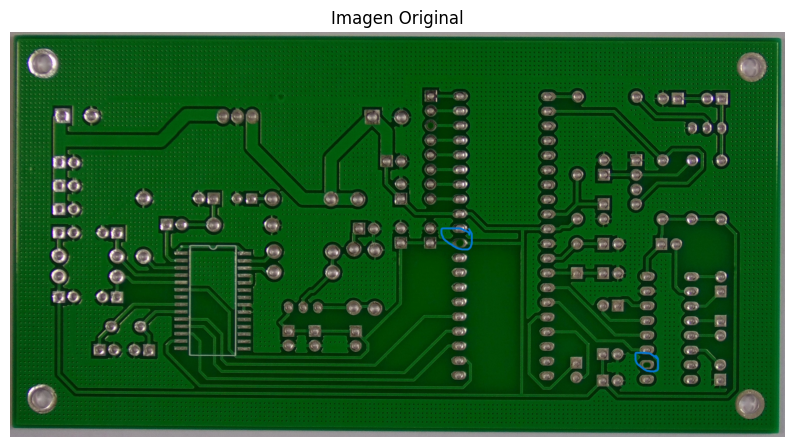

In [ ]:
# CARGAR IMAGEN

img_path = "/content/EfficientSAM/figs/examples/01_missing_hole_01.jpg"
img = Image.open(img_path).convert("RGB")
image_tensor_cpu = transforms.ToTensor()(img).unsqueeze(0).cpu()
image_tensor_gpu = transforms.ToTensor()(img).unsqueeze(0).to(device)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Imagen Original")
plt.show()

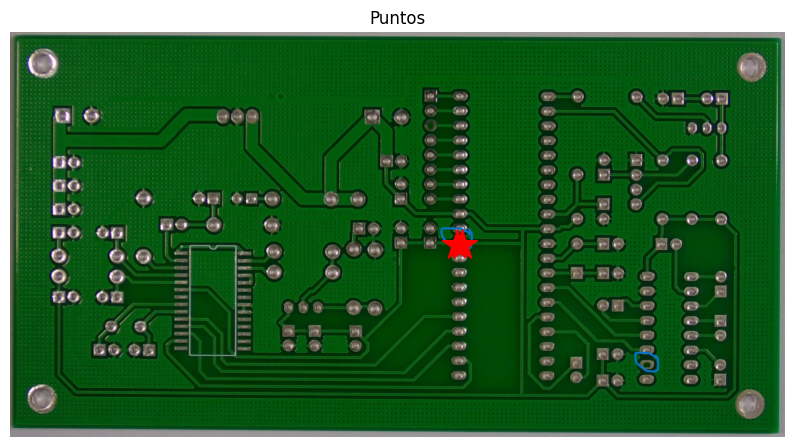

In [ ]:
# DEFINIR LOS PUNTOS

# Poner aquí tus puntos: [ [x1, y1], [x2, y2], ... ]
coords = np.array([[1750, 833], [1770, 834]])
labels = np.array([1, 1])  # foreground (1), background (0)

# Para debug:
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.scatter(coords[:, 0], coords[:, 1], color='red', marker='*', s=500)
plt.axis('off')
plt.title("Puntos")
plt.show()



In [ ]:
# FUNCIONES AUXILIARES

def run_ours_box_or_points(img_pil, pts_sampled, pts_labels, model):
    # Convertir imagen PIL → tensor
    img_tensor = transforms.ToTensor()(img_pil).unsqueeze(0).to(device)

    pts_sampled = torch.tensor(pts_sampled, device=device).reshape(1, 1, -1, 2)
    pts_labels = torch.tensor(pts_labels, device=device).reshape(1, 1, -1)

    with torch.no_grad():
        predicted_logits, predicted_iou = model(
            img_tensor,
            pts_sampled,
            pts_labels,
        )
        sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
        predicted_logits = torch.take_along_dim(predicted_logits, sorted_ids[..., None, None], dim=2)
        mask = torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().numpy()

    return mask

def show_mask(mask, ax, color=(30/255, 144/255, 1, 0.6)):
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    coords = np.array(coords)
    labels = np.array(labels)
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="*", s=marker_size, edgecolor="white", linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="*", s=marker_size, edgecolor="white", linewidth=1.25)



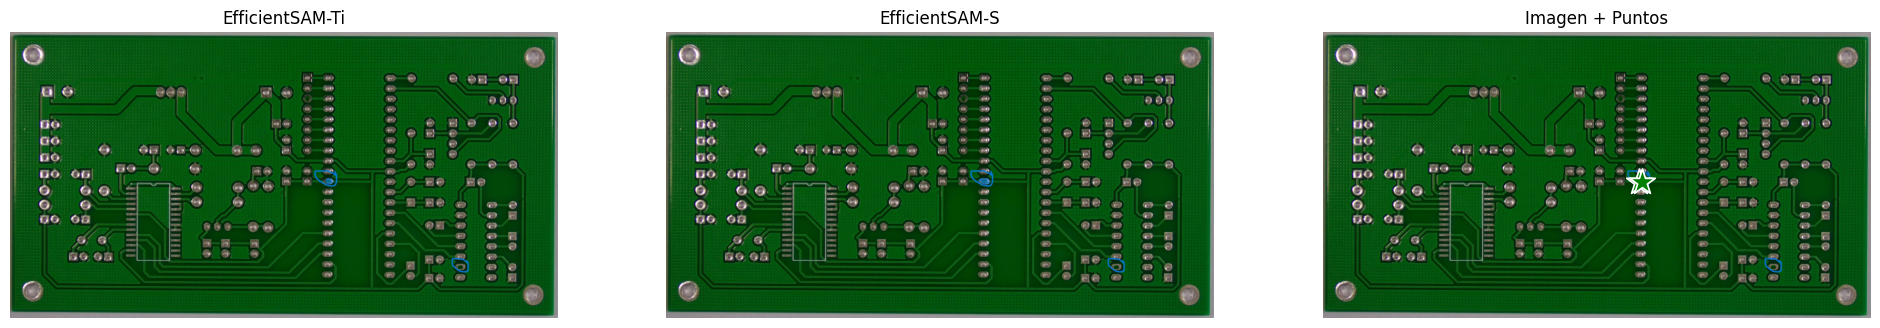

In [ ]:
# --- INFERENCIA Y VISUALIZACION ---

fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# EfficientSAM-Ti (.pt)
ax[0].imshow(img)
mask_ti = run_ours_box_or_points(img, coords, labels, efficient_sam_vitt_model)
show_mask(mask_ti, ax[0])

ax[0].axis('off')
ax[0].set_title("EfficientSAM-Ti")

# EfficientSAM-S (.zip)
ax[1].imshow(img)
mask_s = run_ours_box_or_points(img, coords, labels, efficient_sam_vits_model)
show_mask(mask_s, ax[1])
ax[1].axis('off')
ax[1].set_title("EfficientSAM-S")

# Imagen original
ax[2].imshow(img)
show_points(coords, labels, ax[2])
ax[2].axis('off')
ax[2].set_title("Imagen + Puntos")

plt.show()


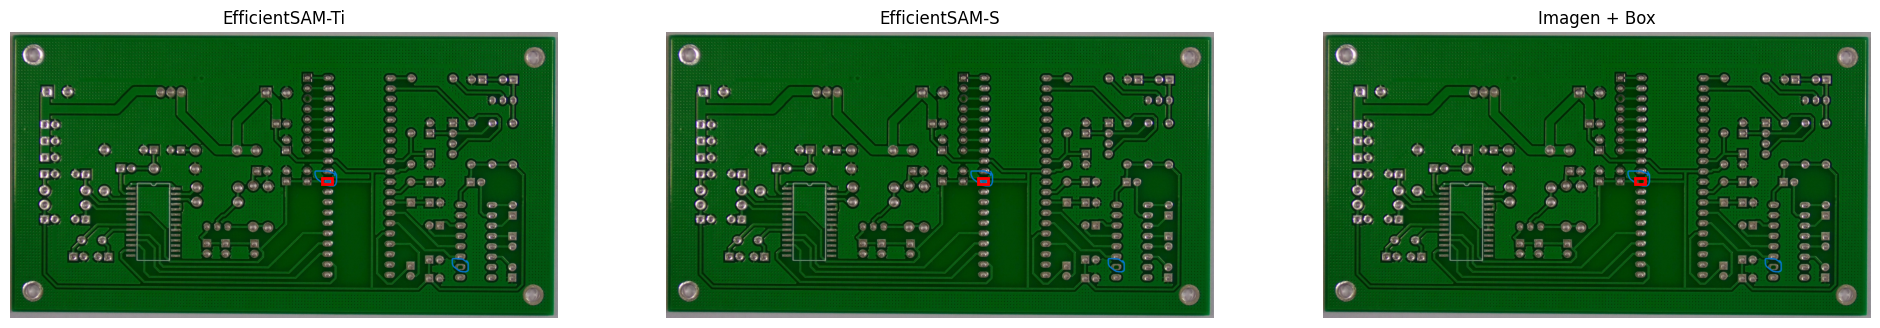

In [ ]:
import matplotlib.patches as patches

# Definir Bounding Box
x1 = 1730
y1 = 811
x2 = 1784
y2 = 844

# Definir puntos y labels
coords = np.array([[x1, y1], [x2, y2]])
labels = np.array([2, 3])

efficient_sam_vitt_model = build_efficient_sam_vitt().to("cuda" if torch.cuda.is_available() else "cpu")
efficient_sam_vitt_model.eval()

efficient_sam_vits_model = build_efficient_sam_vits().to("cuda" if torch.cuda.is_available() else "cpu")
efficient_sam_vits_model.eval()

# Mostrar imagen con resultados
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# EfficientSAM-Ti (.pt)
ax[0].imshow(img)
mask_ti = run_ours_box_or_points(img, coords, labels, efficient_sam_vitt_model)
show_mask(mask_ti, ax[0])

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=2, edgecolor='red', facecolor='none')
ax[0].add_patch(rect)

ax[0].axis('off')
ax[0].set_title("EfficientSAM-Ti")

# EfficientSAM-S (.zip)
ax[1].imshow(img)
mask_s = run_ours_box_or_points(img, coords, labels, efficient_sam_vits_model)
show_mask(mask_s, ax[1])

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=2, edgecolor='red', facecolor='none')
ax[1].add_patch(rect)

ax[1].axis('off')
ax[1].set_title("EfficientSAM-S")

# Imagen original + box
ax[2].imshow(img)

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=2, edgecolor='red', facecolor='none')
ax[2].add_patch(rect)

ax[2].axis('off')
ax[2].set_title("Imagen + Box")

plt.show()

In [ ]:
GRID_SIZE = 16


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git




  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-5bi2unty
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-5bi2unty
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'segment_anything' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'segment_anything'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=59e249767064c8a189211cb

In [ ]:
import sys
sys.path.append('/content/segment-anything')

In [ ]:
!ls /content/segment-anything


ls: cannot access '/content/segment-anything': No such file or directory


In [ ]:
from segment_anything.utils.amg import (
    batched_mask_to_box,
    calculate_stability_score,
    mask_to_rle_pytorch,
    remove_small_regions,
    rle_to_mask,
)

from torchvision.ops.boxes import batched_nms
import torch

def process_small_region(rles):
    new_masks = []
    scores = []
    min_area = 100
    nms_thresh = 0.7
    for rle in rles:
        mask = rle_to_mask(rle[0])

        mask, changed = remove_small_regions(mask, min_area, mode="holes")
        unchanged = not changed
        mask, changed = remove_small_regions(mask, min_area, mode="islands")
        unchanged = unchanged and not changed

        new_masks.append(torch.as_tensor(mask).unsqueeze(0))
        scores.append(float(unchanged))

    masks = torch.cat(new_masks, dim=0)
    boxes = batched_mask_to_box(masks)
    keep_by_nms = batched_nms(
        boxes.float(),
        torch.as_tensor(scores),
        torch.zeros_like(boxes[:, 0]),
        iou_threshold=nms_thresh,
    )

    for i_mask in keep_by_nms:
        if scores[i_mask] == 0.0:
            mask_torch = masks[i_mask].unsqueeze(0)
            rles[i_mask] = mask_to_rle_pytorch(mask_torch)
    masks = [rle_to_mask(rles[i][0]) for i in keep_by_nms]
    return masks

def get_predictions_given_embeddings_and_queries(img, points, point_labels, model):
    predicted_masks, predicted_iou = model(
        img[None, ...], points, point_labels
    )
    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou_scores = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_masks = torch.take_along_dim(
        predicted_masks, sorted_ids[..., None, None], dim=2
    )
    predicted_masks = predicted_masks[0]
    iou = predicted_iou_scores[0, :, 0]
    index_iou = iou > 0.7
    iou_ = iou[index_iou]
    masks = predicted_masks[index_iou]
    score = calculate_stability_score(masks, 0.0, 1.0)
    score = score[:, 0]
    index = score > 0.9
    score_ = score[index]
    masks = masks[index]
    iou_ = iou_[index]
    masks = torch.ge(masks, 0.0)
    return masks, iou_

def run_everything_ours(image_path, model):
    from torchvision.transforms import ToTensor
    import cv2
    model = model.cpu()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_tensor = ToTensor()(image)
    _, original_image_h, original_image_w = img_tensor.shape
    xy = []
    for i in range(GRID_SIZE):
        curr_x = 0.5 + i / GRID_SIZE * original_image_w
        for j in range(GRID_SIZE):
            curr_y = 0.5 + j / GRID_SIZE * original_image_h
            xy.append([curr_x, curr_y])
    xy = torch.from_numpy(np.array(xy))
    points = xy
    num_pts = xy.shape[0]
    point_labels = torch.ones(num_pts, 1)
    with torch.no_grad():
        predicted_masks, predicted_iou = get_predictions_given_embeddings_and_queries(
            img_tensor.cpu(),
            points.reshape(1, num_pts, 1, 2).cpu(),
            point_labels.reshape(1, num_pts, 1).cpu(),
            model.cpu(),
        )
    rle = [mask_to_rle_pytorch(m[0:1]) for m in predicted_masks]
    predicted_masks = process_small_region(rle)
    return predicted_masks

def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask[0].shape[0], mask[0].shape[1], 4))
    img[:,:,3] = 0
    for ann in mask:
        m = ann
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    ax.imshow(img)


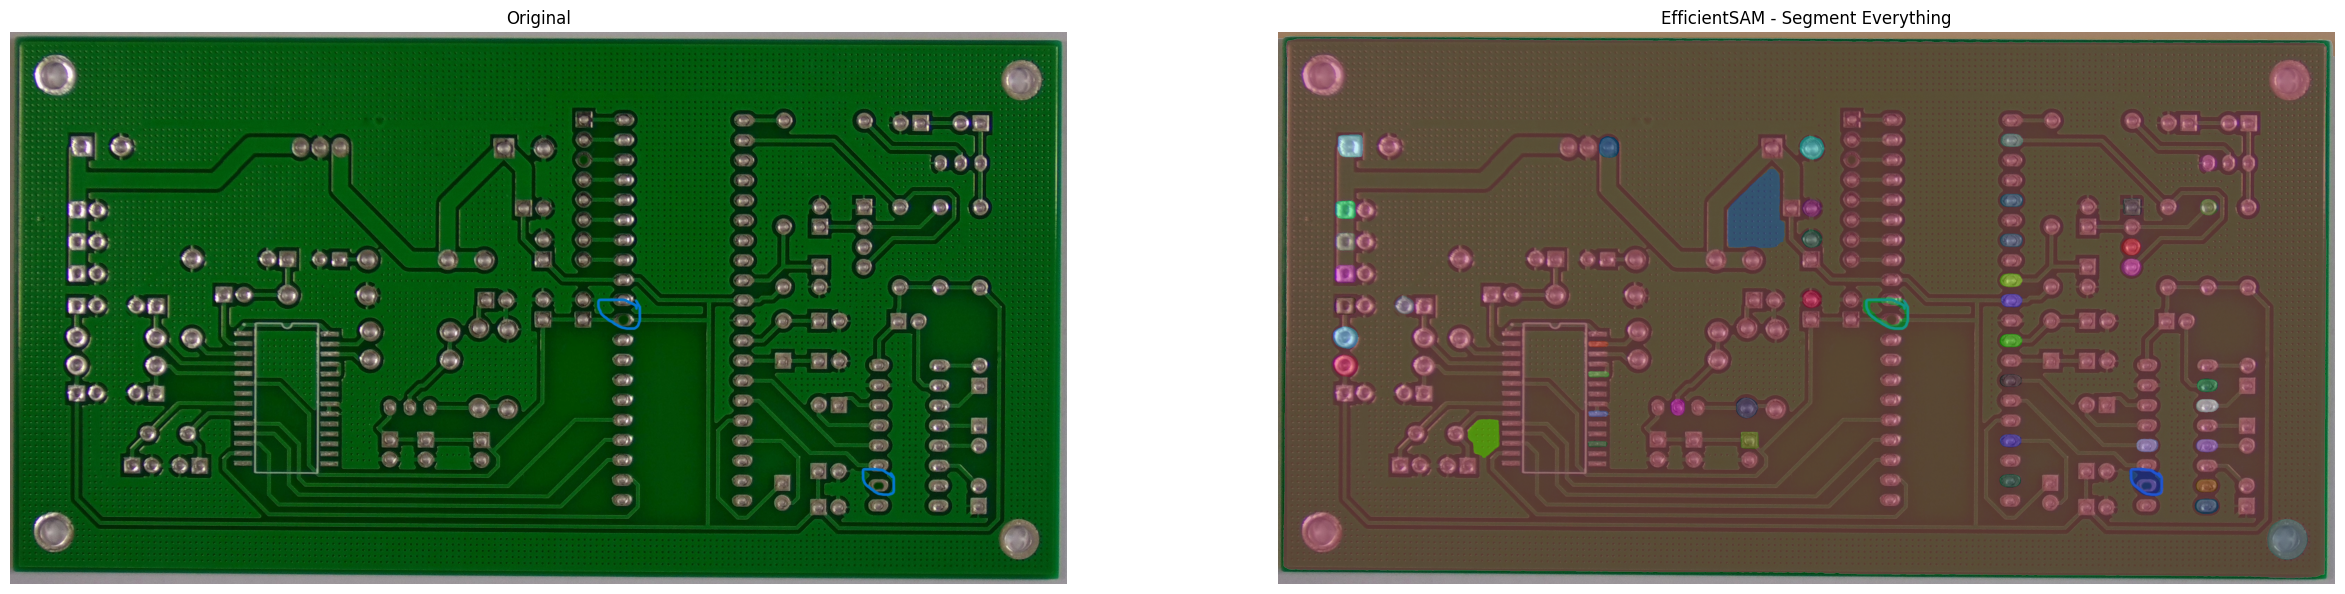

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
fig, ax = plt.subplots(1, 2, figsize=(30, 30))

# Imagen
image_path = "/content/EfficientSAM/figs/examples/01_missing_hole_01.jpg"
image = np.array(Image.open(image_path))

# Mostrar original
ax[0].imshow(image)
ax[0].title.set_text("Original")
ax[0].axis('off')

# Segment Everything
ax[1].imshow(image)
mask_efficient_sam_vits = run_everything_ours(image_path, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[1])
ax[1].title.set_text("EfficientSAM - Segment Everything")
ax[1].axis('off')

plt.show()


EfficientSAM-Ti → tiempo: 0.188 sec, VRAM: 207.3 MB
EfficientSAM-S  → tiempo: 0.302 sec, VRAM: 207.3 MB


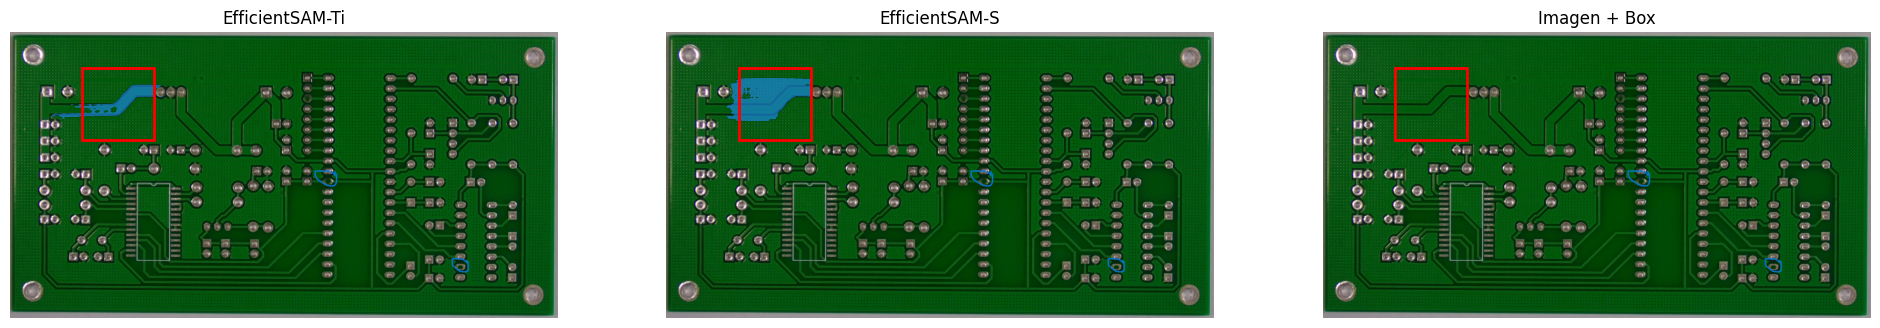

In [ ]:
import time# Definir Bounding Box
x1 = 400
y1 = 200
x2 = 800
y2 = 600

# Definir puntos y labels (bounding box prompt)
coords = np.array([[x1, y1], [x2, y2]])
labels = np.array([2, 3])

# Cargar imagen (modifica la ruta)
image_path = "/content/EfficientSAM/figs/examples/01_missing_hole_01.jpg"
img = np.array(Image.open(image_path))

# Asegurar modelos en GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

efficient_sam_vitt_model = build_efficient_sam_vitt().to(device)
efficient_sam_vitt_model.eval()

efficient_sam_vits_model = build_efficient_sam_vits().to(device)
efficient_sam_vits_model.eval()

# --- EfficientSAM-Ti ---
torch.cuda.empty_cache()
start_time_ti = time.time()

mask_ti = run_ours_box_or_points(img, coords, labels, efficient_sam_vitt_model)

end_time_ti = time.time()
elapsed_time_ti = end_time_ti - start_time_ti
vram_ti = torch.cuda.memory_allocated(device) / 1024**2  # en MB

# --- EfficientSAM-S ---
torch.cuda.empty_cache()
start_time_s = time.time()

mask_s = run_ours_box_or_points(img, coords, labels, efficient_sam_vits_model)

end_time_s = time.time()
elapsed_time_s = end_time_s - start_time_s
vram_s = torch.cuda.memory_allocated(device) / 1024**2  # en MB

# --- Mostrar comparativa ---
print(f"EfficientSAM-Ti → tiempo: {elapsed_time_ti:.3f} sec, VRAM: {vram_ti:.1f} MB")
print(f"EfficientSAM-S  → tiempo: {elapsed_time_s:.3f} sec, VRAM: {vram_s:.1f} MB")

# --- Mostrar visual ---
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# Ti
ax[0].imshow(img)
show_mask(mask_ti, ax[0])
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
ax[0].add_patch(rect)
ax[0].axis('off')
ax[0].set_title("EfficientSAM-Ti")

# S
ax[1].imshow(img)
show_mask(mask_s, ax[1])
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
ax[1].add_patch(rect)
ax[1].axis('off')
ax[1].set_title("EfficientSAM-S")

# Original
ax[2].imshow(img)
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
ax[2].add_patch(rect)
ax[2].axis('off')
ax[2].set_title("Imagen + Box")

plt.show()

In [ ]:
!pip install huggingface_hub
from huggingface_hub import snapshot_download

# Descarga el dataset completo a tu espacio Colab
snapshot_download(
    repo_id="keremberke/pcb-defect-segmentation",
    repo_type="dataset",
    local_dir="/content/pcb-defect-segmentation",
    local_dir_use_symlinks=False
)
import zipfile

base_path = "/content/pcb-defect-segmentation/data/"

# Descomprimir train
with zipfile.ZipFile(base_path + "train.zip", 'r') as zip_ref:
    zip_ref.extractall(base_path + "train/")

# Descomprimir valid
with zipfile.ZipFile(base_path + "valid.zip", 'r') as zip_ref:
    zip_ref.extractall(base_path + "valid/")

# Descomprimir test
with zipfile.ZipFile(base_path + "test.zip", 'r') as zip_ref:
    zip_ref.extractall(base_path + "test/")

print("✅ Todos los splits descomprimidos.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:980: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

test.zip:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

valid-mini.zip:   0%|          | 0.00/155k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

valid.zip:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

README.dataset.txt:   0%|          | 0.00/124 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.roboflow.txt:   0%|          | 0.00/873 [00:00<?, ?B/s]

thumbnail.jpg:   0%|          | 0.00/159k [00:00<?, ?B/s]

pcb-defect-segmentation.py: 0.00B [00:00, ?B/s]

split_name_to_num_samples.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

✅ Todos los splits descomprimidos.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Imagen: {'id': 4, 'license': 1, 'file_name': 'WIN_20221102_19_30_08_Pro_jpg.rf.2689f4baabba3bcafe3fda40f88ca891.jpg', 'height': 480, 'width': 640, 'date_captured': '2023-01-27T13:45:08+00:00'}


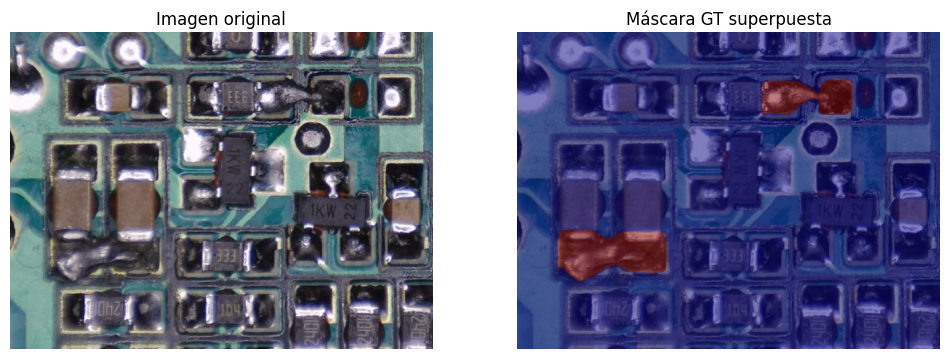

In [ ]:
import json
import os
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Ruta a tu archivo anotaciones COCO
ann_file = "/content/pcb-defect-segmentation/data/train/_annotations.coco.json"
img_dir = "/content/pcb-defect-segmentation/data/train/"

# Cargar COCO
coco = COCO(ann_file)

# Elegir una imagen
img_id = coco.getImgIds()[4]
img_info = coco.loadImgs(img_id)[0]
print("Imagen:", img_info)

# Cargar imagen real
img_path = os.path.join(img_dir, img_info['file_name'])
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Obtener anotaciones de esa imagen
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

# Crear máscara combinada
h, w = img_info['height'], img_info['width']
gt_mask = np.zeros((h, w), dtype=np.uint8)

for ann in anns:
    rle = coco.annToRLE(ann)
    m = maskUtils.decode(rle)
    gt_mask = np.logical_or(gt_mask, m)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Imagen original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(image)
plt.imshow(gt_mask, cmap='jet', alpha=0.5)
plt.title("Máscara GT superpuesta")
plt.axis("off")
plt.show()

In [ ]:
!python EfficientSAM/infer.py \
  --image_path /content/pcb-defect-segmentation/data/train/WIN_20221017_18_50_25_Pro_jpg.rf.879494a79c3899c21e9937c6a7d324ac.jpg\
  --output_dir /content/EfficientSAM/output


python3: can't open file '/content/EfficientSAM/EfficientSAM/infer.py': [Errno 2] No such file or directory
